In [56]:
# tmp include
import sys
sys.path.insert(0, "../TensorTree")
import tensortree 
tensortree.set_backend("tensorflow")
import numpy as np
from learnMSA.msa_hmm.TreeLoss import tree_loss_KL
import tensorflow as tf

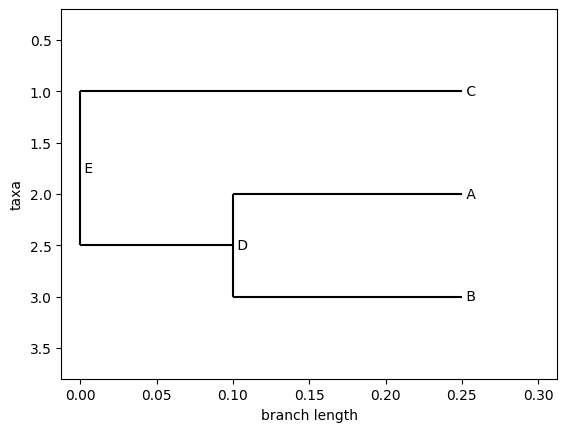

In [158]:
tree_handler = tensortree.TreeHandler.from_newick("((A:0.15,B:0.15)D:0.1,C:0.25)E;")
tree_handler.branch_lengths[...] = 0.
tree_handler.draw()

In [163]:
# leaves have shape (num_leaves, models, L, d)
# here model = L = 1, d=3
leaves = np.array([[0.6, 0.4, 0.], 
                   [0.4, 0.6, 0.], 
                   [0.1, 0.1, 0.8]], dtype=tensortree.util.default_dtype)
# leaves_one_hot = np.array([[1, 0, 0], 
#                    [1, 0, 0], 
#                    [1, 0, 0]], dtype=tensortree.util.default_dtype)
# leaves = leaves_one_hot
#leaves = np.ones((3,3), dtype=tensortree.util.default_dtype)/3.
leaves = leaves[:,np.newaxis,np.newaxis]
leaf_names = ['A', 'B', 'C']
leaves.shape

(3, 1, 1, 3)

In [164]:
rate_matrix = np.array([[[-1., 1./2, 1./2], 
                        [1./2, -1, 1./2], 
                        [1./2, 1./2, -1]]], dtype=tensortree.util.default_dtype)
rate_matrix.shape

(1, 3, 3)

In [165]:
leaf_out_marginal = tensortree.model.compute_leaf_out_marginals(leaves, 
                                                                tree_handler, 
                                                                rate_matrix, 
                                                                tree_handler.branch_lengths,
                                                                equilibrium_logits=np.log([[1./3]*3]),
                                                                leaf_names=leaf_names,
                                                                leaves_are_probabilities=True, 
                                                                return_probabilities=True)
leaf_out_marginal

<tf.Tensor: shape=(3, 1, 1, 3), dtype=float32, numpy=
array([[[[0.4, 0.6, 0. ]]],


       [[[0.6, 0.4, 0. ]]],


       [[[0.5, 0.5, 0. ]]]], dtype=float32)>

In [166]:
tree_loss_KL(leaves, leaf_out_marginal)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5905408>

If only the tree loss is minimized w.r.t. the rate matrix, the branch lengths, the equilibrium and the leaf-distributions, it can be trivially minimized
by extending all branch lengths.

It needs to be combined with an HMM loss.

In [ ]:
# the loss becomes 0 with extending tree branches

tree_handler_vanish = tensortree.TreeHandler.from_newick("((A,B)D,C)E;")
tree_handler_vanish.branch_lengths[...] = 0.1

P = [0.6, 0.39, 0.01]
equilibrium_logits=np.log([P])
same_leaves = np.array([P]*3, dtype=tensortree.util.default_dtype)
same_leaves = same_leaves[:,np.newaxis,np.newaxis]
lam = 1.
exchangeabilities = np.array([[0, lam, lam],
                              [lam, 0, lam],
                              [lam, lam, 0]], dtype=tensortree.util.default_dtype)
exchangeabilities = exchangeabilities[tf.newaxis]
rate_matrix = tensortree.backend.make_rate_matrix(exchangeabilities, [P])

leaf_out_marginal = tensortree.model.compute_leaf_out_marginals(same_leaves, 
                                                                tree_handler_vanish, 
                                                                rate_matrix, 
                                                                tree_handler_vanish.branch_lengths,
                                                                equilibrium_logits=equilibrium_logits,
                                                                leaf_names=leaf_names,
                                                                leaves_are_probabilities=True, 
                                                                return_probabilities=True)

print("rate_matrix=\n", rate_matrix.numpy())
print("transitions=\n", tensortree.backend.make_transition_probs(rate_matrix, tree_handler_vanish.branch_lengths).numpy())
print("leaf_out_marginal=\n", leaf_out_marginal.numpy())
print("tree loss=\n", tree_loss_KL(same_leaves, leaf_out_marginal).numpy())

rate_matrix=
 [[[-0.82000816  0.799508    0.0205002 ]
  [ 1.2300123  -1.2505125   0.0205002 ]
  [ 1.2300123   0.799508   -2.0295203 ]]]
transitions=
 [[[[0.9258583  0.07228822 0.00185354]
   [0.11121263 0.8869339  0.00185354]
   [0.11121262 0.0722882  0.8164992 ]]]


 [[[0.9258583  0.07228822 0.00185354]
   [0.11121263 0.8869339  0.00185354]
   [0.11121262 0.0722882  0.8164992 ]]]


 [[[0.9258583  0.07228822 0.00185354]
   [0.11121263 0.8869339  0.00185354]
   [0.11121262 0.0722882  0.8164992 ]]]


 [[[0.9258583  0.07228822 0.00185354]
   [0.11121263 0.8869339  0.00185354]
   [0.11121262 0.0722882  0.8164992 ]]]]
leaf_out_marginal=
 [[[[0.7154739  0.28211468 0.00241134]]]


 [[[0.7154739  0.28211468 0.00241134]]]


 [[[0.7025442  0.29383194 0.00362379]]]]
tree loss=
 0.02875532
